In [1]:
from pprint import pprint
from pymongo import MongoClient
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt

client = MongoClient()
db = client.Yelp

#Utility functions

def getBusinessesById(business_id):
     return list(db["business"].find({"business_id":{"$in":item_id}}))

def getReviewsById(review_id):
    return list(db["review"].find({"review_id":{"$in":item_id}}))

def getUsersById(user_id):
    return list(db["user"].find({"user_id":{"$in":item_id}}))

def getFields(col):
    return db[col].find({})[0].keys()

# Data aggregation

Since the user is bound to a city, it is sufficient to aggregate relevant data from that city. 

In [2]:
# Aggregate data for each city along with data cleaning/pruning

def aggregateByCity(city, minimum_reviews_business = 10, minimum_reviews_users = 10):
    user_review_map = {}
    # Get list of businesses in a  given city
    businesses = db.business.find({"city": city,
                                   "review_count":{"$gt":minimum_reviews_business}})
    bus_items = [(x['business_id'], x['name']) for x in businesses]
    busids = [x[0] for x in bus_items]
    # Obtain a list of all reviews corresponding to this city
    temp_reviews = db.review.find({"business_id":{"$in":busids}})
    
    # Generate a dict consisting of user_id:[review_id_1,...]
    for r in temp_reviews:
        if not user_review_map.get(r['user_id']):
            user_review_map[r['user_id']] = {}
        else:
            pass
        user_review_map[r['user_id']][r['business_id']] = r['stars']
        
    pruned_review_map = {}
    
    # Prune users with insufficient reviews
    for k,i in user_review_map.items():
        if len(i) > minimum_reviews_users:
            pruned_review_map[k] = i
        else:
            pass
    return busids,pruned_review_map, bus_items

# City counts

A dict of cities and the number of businesses corresponding to that city is generated. Used for further pruning purposes.

In [3]:
# City counts is needed in the future (searching a city with less than sufficient businesses is bound to be inaccurate)
city_counts = {c:0 for c in db.business.distinct('city')}

# Business counts as an array
metrics = []
for b in db.business.find({}):
    city_counts[b['city']] += 1

for i,v in city_counts.items():
    metrics.append(v)

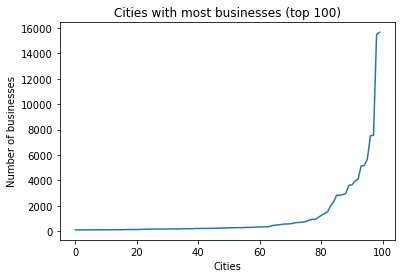

In [4]:
# Plot top businesses with highest business counts(highest n business counts).
def business_numbers_plot(n):
    maximum_content = sorted(metrics)[-1-n:-1]
    x = list(range(len(maximum_content)))
    plt.plot(x, maximum_content)
    plt.title("Cities with most businesses (top {})".format(n))
    plt.xlabel("Cities")
    plt.ylabel("Number of businesses")
    plt.show()

business_numbers_plot(100)

# Pruning plots

Exploratory analysis involves the plotting of number of businesses/users remaining, as a function of minimum number of reviews. Although pruning more does not directly correlate with quality of data, it provides insight on the scarcely reviewed (which might lead to probable inaccuracy). This helps in choosing pruning thresholds.

In [5]:
def pruning_business_plot(c_city="Phoenix", minimum_reviews_b = 100):
    x = list(range(0,minimum_reviews_b + 1,10))
    prune_b_counts = []
    for i in x:
        businesses, review_map, c = aggregateByCity(city = c_city, minimum_reviews_business = i)
        prune_b_counts.append(len(businesses))
    plt.plot(x, prune_b_counts)
    plt.title("Businesses after pruning ({})".format(c_city))
    plt.xlabel("Minimum number of reviews per business")
    plt.ylabel("Number of businesses")
    plt.show()
    
def pruning_user_plot(c_city="Phoenix", minimum_reviews_u = 10):
    x = list(range(0,minimum_reviews_u + 1,1))
    prune_u_counts = []
    for i in x:
        businesses, review_map, c = aggregateByCity(city = c_city, minimum_reviews_users = i)
        prune_u_counts.append(len(review_map))
    plt.plot(x, prune_u_counts)
    plt.title("Users after pruning ({})".format(c_city))
    plt.xlabel("Minimum number of reviews per user")
    plt.ylabel("Number of users")
    plt.show()

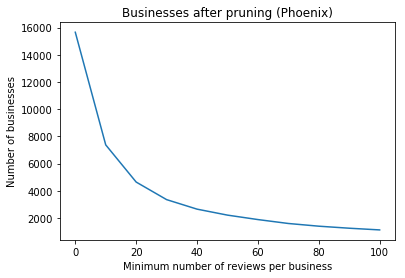

In [6]:
pruning_business_plot()

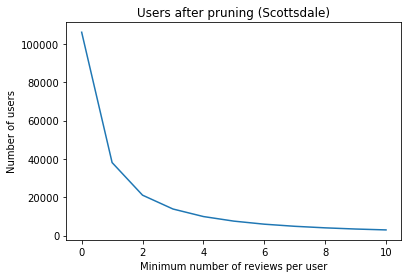

In [7]:
pruning_user_plot("Scottsdale")

In [8]:
db.user.find({}).count()

1183362

# Obtaining data

Data is extracted for the city Phoenix, which is used for the analysis of implemented functions/algorithms.

In [9]:
businesses, user_reviews, business_items = aggregateByCity("Phoenix")

In [10]:
user_reviews

{'CQ7tEwDL_5jpEJzDKKYv4Q': {'-raUM9T-1dKPiB5_vRmFYA': 5,
  '3u4AsqA8glBmGuxtNx5mdQ': 5,
  '4p6Wce7Ed707QS2-yQkvZw': 4,
  '5zHi8eQhO7sO3N15zHgkUg': 5,
  '7m1Oa1VYV98UUuo_6i0EZg': 4,
  'AZQ6eiVqhMalpVL9Bbq6Iw': 4,
  'E25-2ssHwsajyGtsllMXaA': 4,
  'E3qxMkbKxQR6Aca36c53GA': 5,
  'GX4C0SDgzuywFbO2W_g1ow': 5,
  'JCZEK7wiazoM6xiq8YeZyw': 4,
  'JdSF_NucmJZcl1eNlNXZ0Q': 5,
  'KDh82ODr4adz9ck6ltQ_YQ': 5,
  'L6ZPG8lO1tMGmHimSjuEMg': 4,
  'LGOcTvjdBLq13ooCjKnVIQ': 4,
  'NgDyxaeItFSInv7J5paGLQ': 5,
  'OQggqcQglU-lHY3rY-8Lhw': 5,
  'Yea_hg7GjYfOOzMeBSUNjg': 4,
  'ZCzey5aPhd7jYIoHsUfjmQ': 5,
  '_mqUzNXs_sJ1EJYgYZYszg': 4,
  'aXRrMXXoAN7lawHICgmsxw': 5,
  'csy-xJWM68SXabizUIhucA': 3,
  'dja9beNvdd_SmXxn8At5aQ': 3,
  'es3Fq9KNp6Ry994x4T4ZYg': 4,
  'lRL7x-HMBscWyELxEVq85w': 4,
  'muzZW1AqlfdWGMND0jf_kw': 5,
  'pBwOqgpkaDmFUDYX8cbnNQ': 5,
  'pSQFynH1VxkfSmehRXlZWw': 4,
  'rK0Sz8xlX-ni_u_K9CQq-g': 5,
  'wB2mrl_xHyj55UObucaVRA': 5,
  'yNPh5SO-7wr8HPpVCDPbXQ': 4},
 'SR9KgvoaxcBsSd4Gds8LnQ': {'02EYqwh47uVxOa

# Utility functions, effective representation and implementation.

The *user_to_vector* function (expands miniaturized data) accepts the reviews of a user as a dictionary of {business_ids, ratings} and the outline of how the vector should look like, i.e. the $i^{th}$  entry of the vector corresponds to the rating of the business in the $i^{th}$ position.

The *vector to map* function (converts vector to map) accepts a vector of reviews for a user and generates a map of businesses and corresponding ratings for that user.

*get_similarity* calculates a metric of how similar two users are.

*get_similarities* calculates the similarity of a user with all other users and returns a dict of similarity metric corresponding to each user.

*MSE* calculates error in prediction.

*predict_ratings* estimates the ratings of all businesses in the city for a given user. It ignores the user that has a similarity of 1 (exactly same rating pattern). This ensures that at any point during execution, test data does not intersect with training data. 
Since this function accepts a map of review patterns, it can be applied to a random input map that does not belong to this dataset. However, the current analysis is done for users that belong to the current dataset.


A user is generally represented in their sparse format which greatly reduces the space required to store data. The sparse representation is expanded only when necessary (to calculate vector distances).

In [11]:
def user_to_vector(user_review_data, businesses):
    user_vector = []
    for b in businesses:
        cur = user_review_data.get(b)
        if cur is None:
            user_vector.append(0)
        else:
            user_vector.append(cur)
    return np.array(user_vector)

def vector_to_map(user_vector, businesses):
    return {b:r for r,b in zip(user_vector, businesses)}

def get_similarity(u1, u2):
    return (u1@u2)/np.sqrt((u1@u1)*(u2@u2))

def get_similarities(u, businesses, user_reviews):
    
    temp_user_vector = user_to_vector(u, businesses)
    similarities = []
    for k,v in user_reviews.items():
        current_user_vector = user_to_vector(v, businesses)
        similarities.append([k, get_similarity(temp_user_vector, current_user_vector)])
    
    similarities = sorted(similarities, key=lambda x:x[1], reverse = True)
    return similarities


def MSE(u, pred_u):
    current_u = u[u!=0]
    pred_u = pred_u[u!=0]
    diff = current_u - pred_u
    if len(u) == 0:
        return 0
    return np.sqrt((diff@diff)/len(u))

def predict_ratings(u, businesses, user_reviews, min_users = 1000, debug = False):
    
    if min_users == -1:
        min_users = len(user_reviews)-1
        
    sum_ratings = np.zeros(len(businesses))
    sum_weights = np.zeros(len(businesses))
    user_vector = user_to_vector(u, businesses)
    similarities = get_similarities(u, businesses, user_reviews)
    start_index = 1
    if not similarities[0][1] == 1:
        start_index = 0
    k_range = list(range(start_index,min_users+1))
    mse_array = []
    
    for i in k_range:
        current_user = similarities[i][0]
        current_similarity = similarities[i][1]
        current_user_vector = user_to_vector(user_reviews[current_user], businesses)
        sum_ratings += current_user_vector*current_similarity
        sum_weights += (current_user_vector != 0)*current_similarity
        if debug:
            current_user_vector = sum_ratings/(sum_weights + 1*(sum_weights == 0)) 
            mse_array.append(MSE(user_vector, current_user_vector))
    
    if debug:
        plt.title('Prediction accuracy')
        plt.xlabel('Number of users considered for prediction')
        plt.ylabel('MSE')
        plt.plot(k_range, mse_array)
        plt.show()
        
    final_user_vector = sum_ratings/(sum_weights + 1*(sum_weights == 0)) 
    return vector_to_map(final_user_vector, businesses)
        
    

# Prediction accuracy

*predict_ratings* allows a debug mode, which plots the increase in accuracy as a function of number of similar users considered increases. A debug run is shown below.

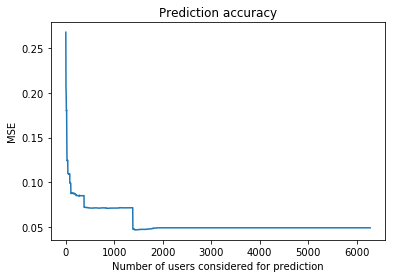

In [12]:
predictions = predict_ratings(user_reviews['CQ7tEwDL_5jpEJzDKKYv4Q'], businesses, user_reviews, -1, True)

In [13]:
user_reviews['CQ7tEwDL_5jpEJzDKKYv4Q']

{'-raUM9T-1dKPiB5_vRmFYA': 5,
 '3u4AsqA8glBmGuxtNx5mdQ': 5,
 '4p6Wce7Ed707QS2-yQkvZw': 4,
 '5zHi8eQhO7sO3N15zHgkUg': 5,
 '7m1Oa1VYV98UUuo_6i0EZg': 4,
 'AZQ6eiVqhMalpVL9Bbq6Iw': 4,
 'E25-2ssHwsajyGtsllMXaA': 4,
 'E3qxMkbKxQR6Aca36c53GA': 5,
 'GX4C0SDgzuywFbO2W_g1ow': 5,
 'JCZEK7wiazoM6xiq8YeZyw': 4,
 'JdSF_NucmJZcl1eNlNXZ0Q': 5,
 'KDh82ODr4adz9ck6ltQ_YQ': 5,
 'L6ZPG8lO1tMGmHimSjuEMg': 4,
 'LGOcTvjdBLq13ooCjKnVIQ': 4,
 'NgDyxaeItFSInv7J5paGLQ': 5,
 'OQggqcQglU-lHY3rY-8Lhw': 5,
 'Yea_hg7GjYfOOzMeBSUNjg': 4,
 'ZCzey5aPhd7jYIoHsUfjmQ': 5,
 '_mqUzNXs_sJ1EJYgYZYszg': 4,
 'aXRrMXXoAN7lawHICgmsxw': 5,
 'csy-xJWM68SXabizUIhucA': 3,
 'dja9beNvdd_SmXxn8At5aQ': 3,
 'es3Fq9KNp6Ry994x4T4ZYg': 4,
 'lRL7x-HMBscWyELxEVq85w': 4,
 'muzZW1AqlfdWGMND0jf_kw': 5,
 'pBwOqgpkaDmFUDYX8cbnNQ': 5,
 'pSQFynH1VxkfSmehRXlZWw': 4,
 'rK0Sz8xlX-ni_u_K9CQq-g': 5,
 'wB2mrl_xHyj55UObucaVRA': 5,
 'yNPh5SO-7wr8HPpVCDPbXQ': 4}

# More utility functions

These utility functions are used to better serve the end user.

In [14]:
def id_name_correlate(business_items):
    b_name_id = {}
    b_id_name = {}
    for idx, nam in business_items:
        b_name_id[nam] = idx
        b_id_name[idx] = nam
    return b_name_id, b_id_name

In [15]:
def get_top_unvisited(user_predictions, user_initial, k = 10):
    ignore_keys = set(user_initial.keys())
    final_keys = list(set(user_predictions.keys()) - ignore_keys)
    final_keys = sorted(final_keys, key = lambda x:user_predictions[x], reverse = True)
    upper_limit = len(final_keys)
    
    # return all prediction ratings in decreasing order of rating.
    k = upper_limit if k == -1 else k
    k = k if upper_limit > k else upper_limit
    return final_keys[:k]

def get_categories(busids):
    category_map = {}
    for row in db.business.find({"business_id":{"$in":busids}}):
        category_map[row['business_id']] = row['categories']
    return category_map

In [16]:
getFields("business")

dict_keys(['_id', 'business_id', 'name', 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours'])

# Comparison of results

The following code is used to compare results obtained from collaborative filtering to that of content based filtering.

In [17]:
businesses, user_reviews, business_items = aggregateByCity("Tempe")

user_reviews

{'sOudRDE_R3VYni0rEYFkSA': {'3JnO3AEqRD8DbXkWP-gTFw': 4,
  '7QSFLU0AGAUqwnQWg3qHqQ': 5,
  'Cv47JcsyTqTxxxowtIlSVw': 5,
  'SurnOSM2bVVN4-Js3G23RQ': 5,
  'diAJlvbE8UrRQ9RN2nZ5Tw': 4,
  'e-hztV3mlfn5z8VmRFBNlw': 5,
  'f-7sTbx8u7c9t1-r_Fdoow': 3,
  'f0pIB6KkSRxc1mxPG70ACQ': 3,
  'gDOuHjntsN37XEjROoQ2Aw': 3,
  'iBihgoxc6Ot7m2D4D3z0QA': 2,
  'jJDKPJLzkoPeytWIzstJrA': 3,
  'kdpMYLkQjrSr6k-51zW28Q': 3,
  'n1AWiP49A5ROroNnbtm0ow': 1,
  'qgAZPDQStZP_Y5XTiQ6UqA': 4,
  'r8hVqm9DeasZ0Bf2KMhbeg': 4,
  'sXfvBdjmMGroE5joJS_X0g': 5,
  'uKKNw68mZZaa1jcyszEbyA': 4,
  'wl0QZqAzr1DelslQ02JGCQ': 4},
 'siVtjO8xrSxbrK-zqXCGew': {'-IZvuqxekWEvJqDw308daQ': 4,
  '366FaRQ1MWEHBhaEKTcriQ': 5,
  '3MdLnbpkvTcsKkMszUv_3g': 5,
  '3QtmPPoceZMOPTQ5lT-_dQ': 5,
  '44vEjV59_w0cm_Lhyif3bQ': 5,
  '4c-O3t8I-JxfUGJDUwvj6Q': 4,
  '4fbH3Yr1D5r5-QD-HReDlg': 5,
  '4jPerp3OfFiWgBPQi8SOUw': 4,
  '8WA2kwCm7AEcDPTJaJjVuQ': 5,
  'AZQKMMvX9m1-uTdLPMzK3g': 2,
  'B8YNa8xI7M4P39RC7cv8wA': 5,
  'BTf8sELl1TjovRc0f-tgJg': 4,
  'CRLvROAjgX-aKI

In [18]:
namemap, idmap = id_name_correlate(business_items)

predictions = predict_ratings(user_reviews['sOudRDE_R3VYni0rEYFkSA'], businesses, user_reviews, 1000)
top_ids = get_top_unvisited(predictions, user_reviews['sOudRDE_R3VYni0rEYFkSA'], -1)

In [19]:
top_ids

['UNhMZrJ-zZjh1XKaj0Z_DQ',
 'dFIgw3b8EzyW3Dt4gPKBxA',
 '8XLpfj__WAby4YXh0mKm7Q',
 'vTqpa_n_sIHS1orUPX0cTQ',
 'tPaweigPsXacvQT8daYT4g',
 '1Drx0N3S-9DGt6uwHZS4Bw',
 '6W-Z2jjICJtAeLW-Z_ErUg',
 'AgE33nKGtNLQkCKQBW44Tw',
 'jga_2HO_j4I7tSYf5cCEnQ',
 'Ob5N8teoqd7TaNi3lOcdxA',
 'FhZ7QinEr-VRGyVgktWKXA',
 '_qptLUIlMUqd0WaQq1weWQ',
 'NXU5CcXh2y0Ns5OJQ2wkgg',
 'B_wVnFqXefH04XSxKik0MQ',
 'pvrWPRP9AENdjXcuPwMDwQ',
 'ACGdW5o32BJtcTM90bRQRA',
 'UbAFFizz1ChyxiIAKYmMLg',
 '1es8u2NyeuXpDqWaUXMbnw',
 'Alk4frpiwOJMHuW-b6f77g',
 't-aTfKrr0HpxcezggYod0g',
 'KjA9PdRnrh_NtN0rVxMGSA',
 'rXceWs_H4PLmY99rGcbk6w',
 'dLDDGXMlMTpJG1iZjeUnVQ',
 'C9wWjU0wfbKgxhxp3d8rhA',
 'CHcCkMXvtAG3hvyzJw3cAg',
 'CoHa0hNT2hsL8RrbocYJdw',
 '4JFMf28hzf-Y0RNMg9KWJA',
 'vGRgynaquP7CNZIxNYmYrw',
 '2m069BaxOm83GEJMuZatUw',
 'yMxutRRiy4AaH-yyVZ1emw',
 'ELcNrObyAY_n0Lp-JpOeHQ',
 'U3Nv8TYgemN_R4cA1PS2uw',
 'PvPWKLdncmYAgrCVfSmWHQ',
 'tklfNgU6O12PyN6Ss8r8nQ',
 'o3ndze48oWtD9FAsJiZSSw',
 'TcQW4DNawqXGACLawaieyg',
 'c4lY3hHlf38c2Bxp9gDcDA',
 

In [20]:
cat = get_categories(top_ids)
c = 0
for k in top_ids:
    if(predictions[k]==5):
        c += 1
    
print(c)
print(len(predictions))

236
2146


236 Businesses have 5 star prediction ratings.

In [21]:
print(predictions['jFyITSwBzUq7tePWJuQqhA'])
print(predictions['wopyolJM2hOAt3dPRmahNA'])
print(predictions['FaFOqx1q26kMSzUlgrYp0Q'])
print(predictions['SoCVWvr5f5lYJEY_62bgAw'])
print(predictions['6YrmJ_pxLSTabcM_FFZhlQ'])
print(predictions['tWiFat101ID5w_wgAPMXhA'])
print(predictions['QuybD_bJcAB2CHcpTfREYg'])
print(predictions['t53w4JlkxTau-G-TzhSWog'])
print(predictions['wopyolJM2hOAt3dPRmahNA'])

5.0
4.16940686964
5.0
4.46216596899
3.61464469275
3.81421214184
4.19561246476
3.3565852339
4.16940686964
